<a href="https://colab.research.google.com/github/Sasmik23/ml-finals/blob/main/ML_finals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Standard library imports
import re
import pickle

# Third-party imports for data manipulation
import numpy as np
import pandas as pd

# Imports for natural language processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

# Imports for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Imports for word embeddings
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Imports for building neural network models
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, LSTM, Dropout, Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

# Imports for model evaluation
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Load the dataset
df = pd.read_csv('movie.csv', engine='python')

## **Distribution of Labels**




[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

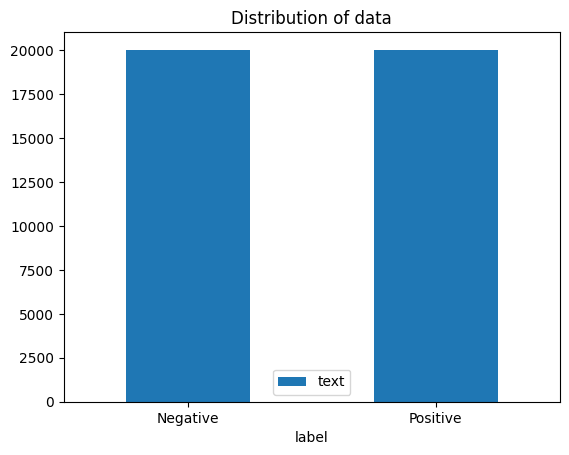

In [ ]:
# Group data by 'label' and count the number of occurrences
data_distribution = df.groupby('label').count()

# Create bar plot of the data distribution
bar_plot = data_distribution.plot(kind='bar', title='Distribution of data')

# Set x-axis labels
labels = ['Negative','Positive']
bar_plot.set_xticklabels(labels, rotation=0)

## **Data Preprocessing**

In [ ]:
# Load contractions
contraction_data = pd.read_csv('contractions.csv', index_col='Contraction')
contraction_data.index = contraction_data.index.str.lower()
contraction_data.Meaning = contraction_data.Meaning.str.lower()
contraction_dict = contraction_data.to_dict()['Meaning']

# Define patterns
line_breaks_pattern = "<br /><br />"
non_alphanumeric_pattern = "[^a-z0-9<>]"
repeated_chars_pattern = r"(.)\1\1+"
repeated_chars_replace_pattern = r"\1\1"
smile_emoji_pattern = r"[8:=;]['`\-]?[)d]+"
sad_emoji_pattern = r"[8:=;]['`\-]?\(+"
neutral_emoji_pattern = r"[8:=;]['`\-]?[\/|l*]"
lol_emoji_pattern = r"[8:=;]['`\-]?p+"
surprise_emoji_pattern = r"[8:=;]['`\-]?[oO]"
wink_emoji_pattern = r"[;]['`\-]?[)]"
hashtag_pattern = r"#(\w+)"



def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Replace line breaks
    text = re.sub(line_breaks_pattern, " ", text)

    # Replace 3 or more consecutive letters by 2 letters
    text = re.sub(repeated_chars_pattern, repeated_chars_replace_pattern, text)

    # Replace emojis
    text = re.sub(r'<3', '<heart>', text)
    text = re.sub(smile_emoji_pattern, '<smile>', text)
    text = re.sub(sad_emoji_pattern, '<sadface>', text)
    text = re.sub(neutral_emoji_pattern, '<neutralface>', text)
    text = re.sub(lol_emoji_pattern, '<lolface>', text)
    text = re.sub(surprise_emoji_pattern, '<surpriseface>', text)
    text = re.sub(wink_emoji_pattern, '<winkface>', text)

    # Replace hashtag
    text = re.sub(hashtag_pattern, '<hashtag> \1', text)

    # Replace contractions
    for contraction, replacement in contraction_dict.items():
        text = text.replace(contraction, replacement)

    # Remove non-alphanumeric characters
    text = re.sub(non_alphanumeric_pattern, ' ', text)

    text = re.sub(r"<.*?>", " ", text)  # Remove any generic HTML tags

    # Replace forward slashes with spaces
    text = re.sub(r'/', ' / ', text)

    # Additional preprocessing steps
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df['cleaned_review'] = df.text.apply(preprocess_text)

In [ ]:
# Set up stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Apply preprocessing to each review
for i in range(len(df)):
    word_list = []
    for word in df["cleaned_review"][i].split():
        # Remove stop words
        if word not in stop_words:
            # Apply lemmatization
            word = lemmatizer.lemmatize(word)
            word_list.append(word)
    # Join the words back into a single string
    df["cleaned_review"][i] = " ".join(word_list)

In [ ]:
X = df['cleaned_review']
y = df['label']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Make copies of the text data for bert/svc
X_train_text = X_train.copy()
X_test_text = X_test.copy()

In [ ]:
# Set parameters
Embedding_dimensions = 100
input_length = 500
vocab_length = 35000

# Create Word2Vec training dataset and train Word2Vec model
Word2vec_train_data = list(map(lambda x: x.split(), X_train))
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=Embedding_dimensions, workers=8, min_count=5)

# Initialize tokenizer and fit on texts
tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_train)
tokenizer.num_words = vocab_length

# Convert texts to sequences and pad sequences
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

# Create embedding matrix
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))
for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

## **Model Implementation**

### CNN

In [ ]:
# Define the embedding layer
embedding_layer = Embedding(input_dim=vocab_length,
                            output_dim=Embedding_dimensions,
                            weights=[embedding_matrix],
                            input_length=input_length,
                            trainable=False)

# Define the CNN model
cnn_model = Sequential([
    embedding_layer,
    Conv1D(100, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])

# Compile the model
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)

# Train the model
history = cnn_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=10,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1,
)

# Make predictions on the test data
y_pred_cnn = cnn_model.predict(X_test)
y_pred_cnn = np.round(y_pred_cnn)  # Round to get 0 or 1 because we're dealing with binary classification

# Calculate accuracy
accuracy_cnn = accuracy_score(y_test, y_pred_cnn) * 100
print(f"CNN Model Accuracy: {accuracy_cnn:.2f}%")

# Calculate F1 score
f1_cnn = f1_score(y_test, y_pred_cnn, average='binary') * 100
print(f"CNN Model F1 Score: {f1_cnn:.2f}%")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 312ms/step - accuracy: 0.6327 - loss: 0.6384 - val_accuracy: 0.7997 - val_loss: 0.4372
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.8236 - loss: 0.3954 - val_accuracy: 0.8413 - val_loss: 0.3692
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.8644 - loss: 0.3247 - val_accuracy: 0.8503 - val_loss: 0.3477
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.8791 - loss: 0.2905 - val_accuracy: 0.8584 - val_loss: 0.3354
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.8897 - loss: 0.2664 - val_accuracy: 0.8647 - val_loss: 0.3295
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.9068 - loss: 0.2415 - val_accuracy: 0.8631 - val_loss: 0.3256
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.9162 - loss: 0.2194 - val_accuracy: 0.8569 - val_loss: 0.3325
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.9216 - loss: 0.2056 - val_accuracy: 0.8694 -

### RNN

In [ ]:
# Define the embedding layer
embedding_layer = Embedding(input_dim=vocab_length,
                            output_dim=Embedding_dimensions,
                            weights=[embedding_matrix],
                            input_length=input_length,
                            trainable=False)

# Define the RNN model
rnn_model = Sequential([
    embedding_layer,
    SimpleRNN(100, return_sequences=False, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid"),
])

# Compile the model
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)

# Train the model
history = rnn_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=15,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1,
)

# Make predictions on the test data
y_pred_rnn = rnn_model.predict(X_test)
y_pred_rnn = np.round(y_pred_rnn)  # Round to get 0 or 1 because we're dealing with binary classification

# Calculate accuracy
accuracy_rnn = accuracy_score(y_test, y_pred_rnn) * 100
print(f"RNN Model Accuracy: {accuracy_rnn:.2f}%")

# Calculate F1 score
f1_rnn = f1_score(y_test, y_pred_rnn, average='binary') * 100
print(f"RNN Model F1 Score: {f1_rnn:.2f}%")

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - accuracy: 0.5515 - loss: 0.7192 - val_accuracy: 0.6737 - val_loss: 0.6070
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.6989 - loss: 0.5700 - val_accuracy: 0.8122 - val_loss: 0.4157
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.8227 - loss: 0.4035 - val_accuracy: 0.8397 - val_loss: 0.3731
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.8461 - loss: 0.3554 - val_accuracy: 0.8453 - val_loss: 0.3516
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.8579 - loss: 0.3330 - val_accuracy: 0.8466 - val_loss: 0.3744
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.8648 - loss: 0.3263 - val_accuracy: 0.8397 - val_loss: 0.3664
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.8623 - loss: 0.3282 - val_accuracy: 0.8612 - val_loss: 0.3555
Epoch 8/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.8698 - loss: 0.3050 - val_accuracy: 0.8581 - val_loss: 0

### CNN + LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Define the CNN_LSTM model with the best hyperparameters
def build_cnn_lstm_model():
    model = Sequential()

    # Embedding Layer (Pretrained)
    model.add(Embedding(input_dim=vocab_length,
                        output_dim=Embedding_dimensions,
                        weights=[embedding_matrix],
                        input_length=input_length,
                        trainable=False))

    # Conv1D Layer 1
    model.add(Conv1D(
        filters=192,  # Best filters for Conv1D Layer 1
        kernel_size=5,  # Best kernel size for Conv1D Layer 1
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    # Conv1D Layer 2
    model.add(Conv1D(
        filters=192,  # Best filters for Conv1D Layer 2
        kernel_size=5,  # Best kernel size for Conv1D Layer 2
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    # LSTM Layer
    model.add(LSTM(
        units=64,  # Best LSTM units
        return_sequences=False,
        activation='tanh'
    ))

    # Dropout
    model.add(Dropout(0.4))  # Best dropout rate for LSTM layer

    # Dense Layer
    model.add(Dense(
        units=96,  # Best dense units
        activation='relu',
        kernel_regularizer="l2"
    ))
    model.add(Dropout(0.3))  # Best dropout rate for Dense layer

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with the best learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.001),  # Best learning rate
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Build the CNN_LSTM model
cnn_lstm_model = build_cnn_lstm_model()

# Train the CNN_LSTM model
history = cnn_lstm_model.fit(
    X_train, y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=512,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

# Evaluate on the test set
y_pred_cnn_lstm = cnn_lstm_model.predict(X_test)
y_pred_cnn_lstm = np.round(y_pred_cnn_lstm)

accuracy = accuracy_score(y_test, y_pred_cnn_lstm) * 100
f1 = f1_score(y_test, y_pred_cnn_lstm, average='binary') * 100

print(f"CNN_LSTM Model Accuracy: {accuracy:.2f}%")
print(f"CNN_LSTM Model F1 Score: {f1:.2f}%")


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 177ms/step - accuracy: 0.6945 - loss: 1.2307 - val_accuracy: 0.8255 - val_loss: 0.7954
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 166ms/step - accuracy: 0.8527 - loss: 0.6829 - val_accuracy: 0.7883 - val_loss: 0.6318
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.8809 - loss: 0.4559 - val_accuracy: 0.8598 - val_loss: 0.4256
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.9071 - loss: 0.3195 - val_accuracy: 0.8467 - val_loss: 0.3873
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.9264 - loss: 0.2419 - val_accuracy: 0.8438 - val_loss: 0.4137
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.9544 - loss: 0.1651 - val_accuracy: 0.8334 - val_loss: 0.4497
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.9670 - loss: 0.1230 - val_accuracy: 0.8555 - val_loss: 0.4602
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
CNN_LSTM Model Accuracy: 85.25%
CNN_LSTM Model F1 Score: 86.73%


### BERT (Distil ver)

In [ ]:
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, create_optimizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Preprocessing and Dataset Setup
#X = df['cleaned_review'].values
#y = df['label'].values
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenization
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(list(X_train_text), truncation=True, padding=True, max_length=128, return_tensors='tf')
test_encodings = tokenizer(list(X_test_text), truncation=True, padding=True, max_length=128, return_tensors='tf')

# Convert labels to tensors
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).shuffle(len(X_train_text)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(32)

# Load DistilBERT for classification
model = TFDistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
)

# Create optimizer
num_train_steps = len(train_dataset) * 5  # 5 epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=5e-5,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
    num_warmup_steps=0
)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=5,
    batch_size=1024,
    validation_split=0.1,
)

# Evaluate the model
y_pred_probs = model.predict(test_dataset).logits
y_pred_bert = tf.argmax(y_pred_probs, axis=1).numpy()

# Convert true labels to numpy
y_test_numpy = y_test.numpy()

# Calculate accuracy and F1 score
bert_accuracy = accuracy_score(y_test_numpy, y_pred_bert) * 100
bert_f1 = f1_score(y_test_numpy, y_pred_bert, average='binary') * 100

print(f"DistilBERT Accuracy: {bert_accuracy:.2f}%")
print(f"DistilBERT F1 Score: {bert_f1:.2f}%")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/10
1000/1000 [==============================] - 481s 469ms/step - loss: 0.3325 - accuracy: 0.8562 - val_loss: 0.2731 - val_accuracy: 0.8859
Epoch 2/10
1000/1000 [==============================] - 462s 462ms/step - loss: 0.1808 - accuracy: 0.9303 - val_loss: 0.2791 - val_accuracy: 0.8931
Epoch 3/10
1000/1000 [==============================] - 462s 462ms/step - loss: 0.0702 - accuracy: 0.9761 - val_loss: 0.4005 - val_accuracy: 0.8848
Epoch 4/10
1000/1000 [==============================] - 462s 462ms/step - loss: 0.0275 - accuracy: 0.9921 - val_loss: 0.4617 - val_accuracy: 0.8898
Epoch 5/10
1000/1000 [==============================] - 463s 463ms/step - loss: 0.0123 - accuracy: 0.9973 - val_loss: 0.5469 - val_accuracy: 0.8895
Epoch 6/10
1000/1000 [==============================] - 462s 462ms/step - loss: 0.0080 - accuracy: 0.9984 - val_loss: 0.5469 - val_accuracy: 0.8895
Epoch 7/10
1000/1000 [==============================] - 462s 462ms/step - loss: 0.0078 - accuracy: 0.9984 - val_

## **Conclusion**


Confusion Matrix for CNN Model:
 [[3398  568]
 [ 536 3498]]


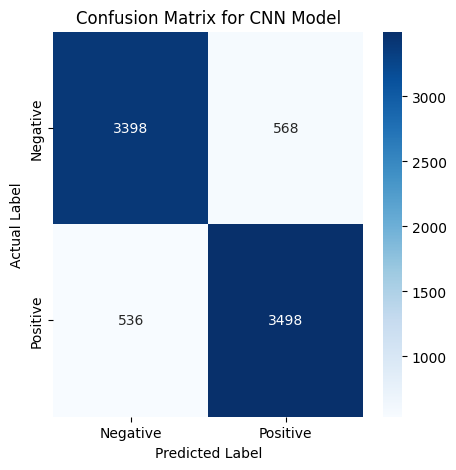

Confusion Matrix for RNN Model:
 [[3108  858]
 [ 300 3734]]


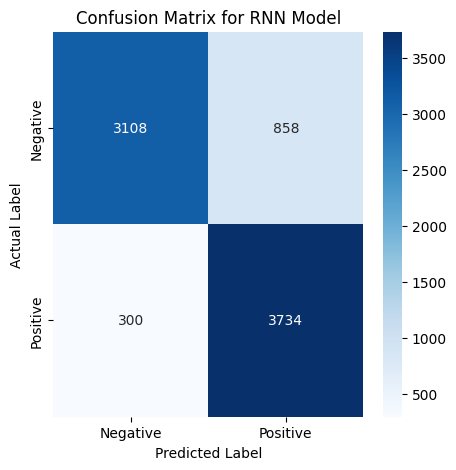

Confusion Matrix for CNN-LSTM Model:
 [[2964 1002]
 [ 178 3856]]


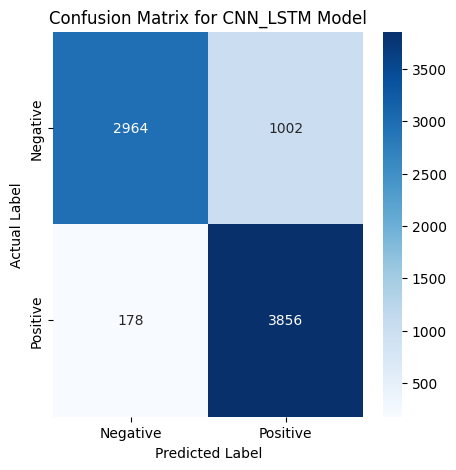

Confusion Matrix for DistilBERT Model:
 [[3524  442]
 [ 442 3592]]


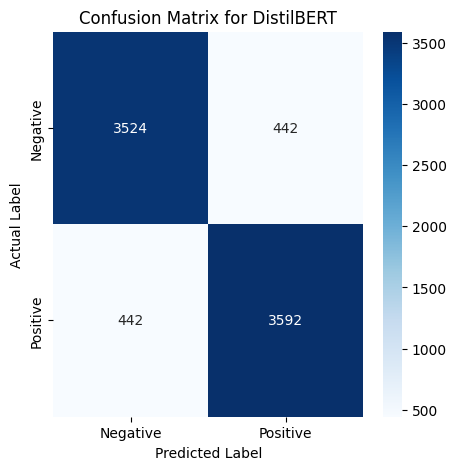

In [ ]:
def plot_confusion_matrix(cm, model_name, labels=['Negative', 'Positive']):
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()


# Confusion Matrix for CNN
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
print("Confusion Matrix for CNN Model:\n", cm_cnn)
plot_confusion_matrix(cm_cnn, 'CNN Model')

# Confusion Matrix for RNN
cm_rnn = confusion_matrix(y_test, y_pred_rnn)
print("Confusion Matrix for RNN Model:\n", cm_rnn)
plot_confusion_matrix(cm_rnn, 'RNN Model')

# Confusion Matrix for CNN-LSTM
cm_cnn_lstm = confusion_matrix(y_test, y_pred_cnn_lstm)
print("Confusion Matrix for CNN-LSTM Model:\n", cm_cnn_lstm)
plot_confusion_matrix(cm_cnn_lstm, 'CNN_LSTM Model')

# Confusion Matrix for DistilBERT
cm_bert = confusion_matrix(y_test_numpy, y_pred_bert)
print("Confusion Matrix for DistilBERT Model:\n", cm_bert)
plot_confusion_matrix(cm_bert, 'DistilBERT')
